# 3-2 Classification Optimization 
> EfficientNet
- swish function

[]

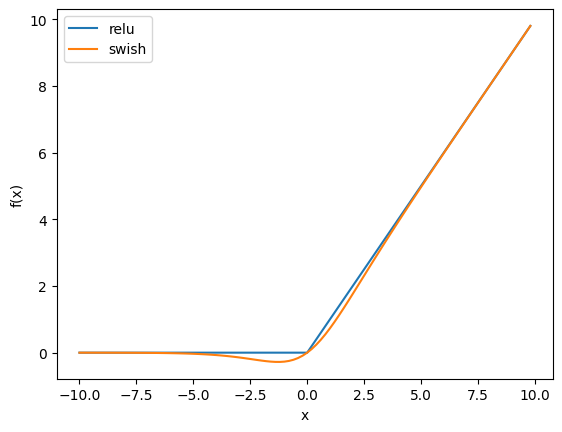

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

x = np.arange(-10, 10, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, x * expit(x), label='swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.plot()

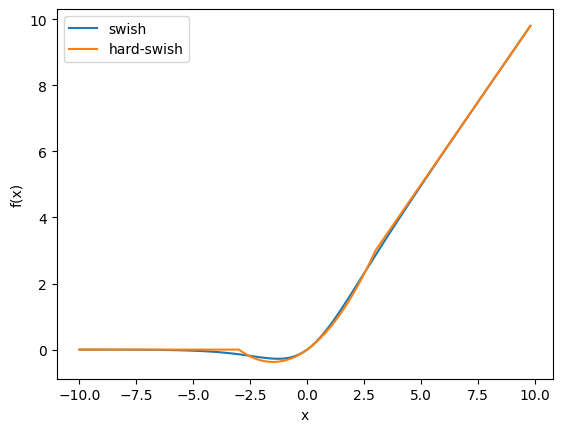

In [4]:
def relu6(x):
    return np.minimum(np.maximum(x, 0), 6)

x = np.arange(-10, 10, 0.2)

plt.plot(x, x * expit(x), label='swish')
plt.plot(x, x * relu6(x+3)/6, label='hard-swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

## EfficientNet Model
> Inverse residual block

In [6]:
import keras
from keras import layers

/Users/jameshoyu/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [37]:
def inv_res_block(inputs, filters_out, kernel_size, strides, dropout_rate, expand_ratio):
    # 팽창 단계
    filters_in = inputs.shape[-1]
    filters = filters_in * expand_ratio
    if expand_ratio > 1:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
    else:
        x = inputs

    # 깊이별 분리 합성곱
    if strides == 2:
        x = layers.ZeroPadding2D(padding=padding_size(x.shape, kernel_size))(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, use_bias=False,
                               padding='same' if strides == 1 else 'valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # SE 블록
    se_input = x
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = layers.Conv2D(int(filters_in * 0.25), 1, padding='same', activation='swish')(x)
    x = layers.Conv2D(filters, 1, padding='same', activation='sigmoid')(x)
    x = layers.Multiply()([se_input, x])

    # 출력 단계
    x = layers.Conv2D(filters_out, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if strides == 1 and filters_in == filters_out:
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, noise_shape=(None, 1, 1, 1))(x)
            x = layers.Add()([x, inputs])
    return x

In [38]:
def padding_size(input_size, kernel_size):
    # 입력 크기가 짝수이면 위쪽과 왼쪽 패딩을 하나 줄입니다.
    padding = kernel_size //2 
    if input_size[1] % 2 == 0: 
        return ((padding - 1, padding), 
                (padding - 1, padding))
    else: 
        return padding

In [39]:
import math

def round_repeats(repeats, depth):
    """repeats * depth 보다 더 큰 정수를 반환"""
    return int(math.ceil(repeats * depth))

def round_filters(filters, width):
    """filters * width 보다 크고 8의 배수가 되도록 만듭니다"""
    filters *= width
    new_filters = max(8, int(filters + 4) // 8 * 8)
    if new_filters < 0.9 * filters:
        new_filters += 8
    return int(new_filters)

## EfficientNet Model

In [40]:
width = 1.0
depth = 1.0
inputs = layers.Input(shape=(224, 224, 3))

x = layers.Rescaling(1.0 / 255.0)(inputs)
x = layers.Normalization()(x)
x = layers.Rescaling(1.0 / np.sqrt([0.229, 0.224, 0.225]))(x)
x = layers.ZeroPadding2D(padding=padding_size(x.shape, 3))(x)
x = layers.Conv2D(round_filters(32, width), 3, strides=2, padding='valid', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

In [41]:
blocks_params = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_out": 16,
        "strides": 1
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_out": 24,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_out": 40,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_out": 80,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_out": 112,
        "strides": 1
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_out": 192,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_out": 320,
        "strides": 1
    },
]

In [42]:
filter_expand_ratio = 1
block_count = 0
total_blocks = float(sum(round_repeats(params["repeats"], depth) for params in blocks_params))
for params in blocks_params:
    # depth에 따라 블록의 입력과 출력 필터를 늘립니다.
    filters_out = round_filters(params['filters_out'], width)
    strides = params["strides"]
    for j in range(round_repeats(params["repeats"], depth)):
        # 반복의 첫 번째 블록을 제외한 나머지 블록은 스트라이드 1입니다.
        if j > 0:
            strides = 1
        dropout_rate = 0.2 * block_count / total_blocks
        x = inv_res_block(x, filters_out, params['kernel_size'],
                          strides, dropout_rate, filter_expand_ratio)
        block_count += 1
    filter_expand_ratio = 6

In [29]:
x = layers.Conv2D(round_filters(1280, width), 1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1000, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 1280) │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 1280) │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 1280) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     1,281,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,328,079 (5.07 MB)

 Trainable params: 1,325,448 (5.06 MB)

 Non-trainable params: 2,631 (10.28 KB)

In [45]:
import numpy as np
from PIL import Image
dog_png = np.array(Image.open('images/dog.png'))

In [47]:
from keras.applications import efficientnet

efficientnetb0 = keras.applications.EfficientNetB0()
predictions = efficientnetb0.predict(dog_png[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


[[('n02099712', 'Labrador_retriever', np.float32(0.36829475)),
  ('n02104029', 'kuvasz', np.float32(0.1933986)),
  ('n02099601', 'golden_retriever', np.float32(0.061458256)),
  ('n02111500', 'Great_Pyrenees', np.float32(0.05779683)),
  ('n02095889', 'Sealyham_terrier', np.float32(0.017902743))]]